<a href="https://colab.research.google.com/github/densivanov/data_analytics_projects/blob/main/uber_analysis/BigQuery_analysis_PySparkSQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installing libraries

In [17]:
import pandas as pd

!pip install pyspark py4j
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Analysis").getOrCreate()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Getting data

In [18]:
df = spark.read.parquet("/content/yellow_tripdata_2023-01.parquet")

In [19]:
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2023-01-01 00:32:10|  2023-01-01 00:40:36|            1.0|         0.97|       1.0|                 N|         161|         141|           2|        9.3|  1.0|    0.5|       0.

- добавить текст к вопросам
- добавить ещё вопросов (сложные)

# Creating a view

In [20]:
# Create SQL table
spark.read.parquet("/content/yellow_tripdata_2023-01.parquet") \
          .createOrReplaceTempView("df")

In [21]:
spark.sql('''
          SELECT *
          FROM df


''').show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2023-01-01 00:32:10|  2023-01-01 00:40:36|            1.0|         0.97|       1.0|                 N|         161|         141|           2|        9.3|  1.0|    0.5|       0.

#Analysis


#### Question №1: Output the average, maximum and minimum distance of the trip

In [22]:
spark.sql('''SELECT ROUND(AVG(trip_distance),2) AS avg_distance,
                    ROUND(MAX(trip_distance),2) AS max_distance,
                    ROUND(MIN(trip_distance),2) AS min_distance
             FROM df
             
             
             
             ''') \
     .show()

+------------+------------+------------+
|avg_distance|max_distance|min_distance|
+------------+------------+------------+
|        3.85|   258928.15|         0.0|
+------------+------------+------------+



As we can see, the average distance of the trip is 3.85 km.

#### Question №2: Show metrics on the trip time

In [28]:
spark.sql('''SELECT ROUND(AVG(DATEDIFF(minute,tpep_pickup_datetime,tpep_dropoff_datetime)),2) AS avg_minute_trip,
                    ROUND(MAX(DATEDIFF(minute,tpep_pickup_datetime,tpep_dropoff_datetime)),2) AS max_minute_trip,
                    ROUND(MIN(DATEDIFF(minute,tpep_pickup_datetime,tpep_dropoff_datetime)),2) AS min_minute_trip
             FROM df
             
             
             
             ''') \
     .show()

+---------------+---------------+---------------+
|avg_minute_trip|max_minute_trip|min_minute_trip|
+---------------+---------------+---------------+
|          15.18|          10029|            -29|
+---------------+---------------+---------------+



The average trip takes 15 minutes. However we have outliers in the data let's see where exactly

#### Checking outliers in datetime

In [32]:
spark.sql('''SELECT tpep_pickup_datetime,
                    tpep_dropoff_datetime,
                    passenger_count,
                    trip_distance,
                    payment_type
                    fare_amount,
                    tip_amount,
                    total_amount
             FROM df
             WHERE DATEDIFF(minute,tpep_pickup_datetime,tpep_dropoff_datetime) IN (SELECT MAX(DATEDIFF(minute,tpep_pickup_datetime,tpep_dropoff_datetime))
                                                                                   FROM df)
             
             
             
             ''') \
     .show()

+--------------------+---------------------+---------------+-------------+-----------+----------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|fare_amount|tip_amount|total_amount|
+--------------------+---------------------+---------------+-------------+-----------+----------+------------+
| 2023-01-23 11:21:51|  2023-01-30 10:31:02|            1.0|          0.0|          2|       0.0|         4.5|
+--------------------+---------------------+---------------+-------------+-----------+----------+------------+



It is not difficult to understand that this is most likely a failure in information. You can see that the distance of the trip is 0 km, but the final cost is 4.5 dollars, which is quite strange

#### Question №3: How many passengers per hour on average?

In [41]:
spark.sql('''SELECT EXTRACT(HOUR FROM tpep_pickup_datetime) AS hour,
                    ROUND(AVG(passenger_count),2) AS avg_pass_count,
                    MAX(passenger_count) AS max_pass_count
             FROM df
             GROUP BY EXTRACT(HOUR FROM tpep_pickup_datetime)
             ORDER BY ROUND(AVG(passenger_count),2) DESC
             
             
             
             
             ''') \
     .show()

+----+--------------+--------------+
|hour|avg_pass_count|max_pass_count|
+----+--------------+--------------+
|   2|          1.44|           6.0|
|   1|          1.43|           6.0|
|   0|          1.42|           8.0|
|  22|          1.41|           6.0|
|   3|          1.41|           7.0|
|  23|           1.4|           6.0|
|  21|           1.4|           6.0|
|   4|          1.39|           6.0|
|  16|          1.38|           8.0|
|  20|          1.38|           8.0|
|  15|          1.38|           8.0|
|  19|          1.37|           7.0|
|  14|          1.37|           8.0|
|  13|          1.36|           8.0|
|  17|          1.36|           8.0|
|  12|          1.35|           7.0|
|  18|          1.35|           8.0|
|  11|          1.34|           8.0|
|  10|          1.32|           6.0|
|   5|           1.3|           6.0|
+----+--------------+--------------+
only showing top 20 rows



The best hour for the average number of customers is 2 hours, but it is clear that on average there is one passenger everywhere. The quantity does not differ critically.


The table also shows the maximum number of passengers at a time

**Show the table**

In [42]:
spark.sql('''
          SELECT *
          FROM df


''').show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2023-01-01 00:32:10|  2023-01-01 00:40:36|            1.0|         0.97|       1.0|                 N|         161|         141|           2|        9.3|  1.0|    0.5|       0.

#### Question №4: Display useful data by RateCode

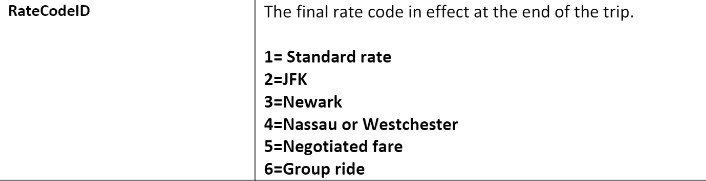

In [48]:
spark.sql('''
          SELECT RatecodeID AS rate_code,
                 ROUND(AVG(total_amount),2) AS avg_total_amount,
                 COUNT(tpep_pickup_datetime) AS count_trips,
                 ROUND(AVG(passenger_count),2) AS avg_pass_count
          FROM df
          GROUP BY RatecodeID 
          ORDER BY RatecodeID ASC


''').show()

+---------+----------------+-----------+--------------+
|rate_code|avg_total_amount|count_trips|avg_pass_count|
+---------+----------------+-----------+--------------+
|     null|           29.13|      71743|          null|
|      1.0|           23.74|    2839305|          1.36|
|      2.0|           89.09|     114239|          1.52|
|      3.0|           107.4|       8958|          1.64|
|      4.0|          119.95|       4366|           1.4|
|      5.0|           81.39|      15043|          1.52|
|      6.0|          132.78|          6|           0.5|
|     99.0|           37.76|      13106|           1.0|
+---------+----------------+-----------+--------------+



We obviously don't have an ideal dataset, because we see some unfamiliar values that are not described in the documentation. This can all be attributed to system failures and just ignore them. 


There is also a relationship between the type of trip and the final price, which is quite logical

#### Question №5: What type of payment is used most often?

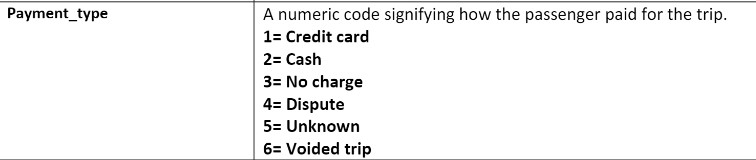

In [60]:
spark.sql('''
          SELECT  payment_type,
                  CASE 
                      WHEN payment_type = 1 THEN 'Credit Card'
                      WHEN payment_type = 2 THEN 'Cash'
                      WHEN payment_type = 3 THEN 'No charge'
                      WHEN payment_type = 4 THEN 'Dispute'
                      WHEN payment_type = 5 THEN 'Unknown'
                      WHEN payment_type = 6 THEN 'Voided trip'
                    ELSE 'no_info'
                  END AS payment_type,
                  COUNT(payment_type) AS count_payment_type,
                  ROUND(AVG(total_amount),2) AS avg_total_amount,
                   ROUND(AVG(tip_amount),2) AS avg_tip_amount,
                  ROUND(MAX(total_amount),2) AS max_total_amount


                 
          FROM df
          GROUP BY payment_type
          ORDER BY COUNT(payment_type) DESC
       


''').show()

+------------+------------+------------------+----------------+--------------+----------------+
|payment_type|payment_type|count_payment_type|avg_total_amount|avg_tip_amount|max_total_amount|
+------------+------------+------------------+----------------+--------------+----------------+
|           1| Credit Card|           2411462|            28.3|          4.17|          545.55|
|           2|        Cash|            532241|           23.03|           0.0|          1169.4|
|           0|     no_info|             71743|           29.13|          3.73|          209.05|
|           4|     Dispute|             33297|            2.55|          0.05|           603.5|
|           3|   No charge|             18023|           10.51|          0.03|          1000.0|
+------------+------------+------------------+----------------+--------------+----------------+



The table shows that a credit card is most often used to pay for a trip.

I also brought out the main indicators by type of payment.

#### Question №6: Show the biggest tip amount

In [62]:
spark.sql('''
          SELECT DATEDIFF(minute,tpep_pickup_datetime,tpep_dropoff_datetime) AS trip_minutes,
                 passenger_count,
                 trip_distance,
                 RatecodeID,
                 payment_type,
                 fare_amount,
                 tip_amount,
                 total_amount
                 
          FROM df
          WHERE tip_amount IN (SELECT MAX(tip_amount)
                               FROM df)
       


''').show()

+------------+---------------+-------------+----------+------------+-----------+----------+------------+
|trip_minutes|passenger_count|trip_distance|RatecodeID|payment_type|fare_amount|tip_amount|total_amount|
+------------+---------------+-------------+----------+------------+-----------+----------+------------+
|           8|            2.0|         1.46|       1.0|           1|       10.7|     380.8|       395.5|
+------------+---------------+-------------+----------+------------+-----------+----------+------------+



The maximum tip was $ 380, but it is clear that the trip took only 8 minutes, perhaps we are working with an outlier again